In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 30.7 MB/s 
     |████████████████████████████████| 182 kB 66.8 MB/s 
     |████████████████████████████████| 7.6 MB 45.7 MB/s 


In [ ]:
import torch 
import numpy as np

from nltk.tokenize import sent_tokenize 

import pandas as pd
from pathlib import Path 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch import nn

from transformers import AutoTokenizer, GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Model

In [ ]:
!unzip dataset_all_genres.csv.zip

Archive:  dataset_all_genres.csv.zip
  inflating: dataset_all_genres.csv  


In [ ]:
df = pd.read_csv('dataset_all_genres.csv')
df['primary_genre'].value_counts()

Rock       25177
Pop        13759
Indie      12998
Hip Hop     8412
Country     7377
R&B         5309
Blues       2038
EDM         1758
Name: primary_genre, dtype: int64

In [ ]:
df.shape

(95076, 4)

In [ ]:
df_sampled = df.groupby('primary_genre').sample(n=500, random_state=200)

In [ ]:
model_name = "distilgpt2"

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [ ]:
class GPT2Classifier(nn.Module):
  def __init__(self, embedding_size, num_classes,max_seq_len, gpt_model_name):
    super(GPT2Classifier,self).__init__()
    self.gpt2 = GPT2Model.from_pretrained(gpt_model_name)
    self.classifier_head = nn.Linear(embedding_size*max_seq_len, num_classes)

      
  def forward(self, input_id, mask):
    gpt_out, _ = self.gpt2(input_ids=input_id, attention_mask=mask, return_dict=False)
    batch_size = gpt_out.shape[0]
    linear_output = self.classifier_head(gpt_out.view(batch_size,-1))
    return linear_output

In [ ]:
df_sampled['primary_genre'].value_counts()

Blues      500
Country    500
EDM        500
Hip Hop    500
Indie      500
Pop        500
R&B        500
Rock       500
Name: primary_genre, dtype: int64

In [ ]:
"""
Prepare the dataset to finetune a transformer model

Arguments:
            ds_choice: str. "small" or "large". (i.e. selects which of the two datasets)
            split: str. "train" or "test".
            truncation: int. If -1: no truncation on sentences. Otherwise: truncate to this specific length.
""" 
genre_labels = {'Blues': 0, 'Country': 1, 'EDM': 2, 'Hip Hop': 3, 'Indie': 4, 'Pop': 5, 'R&B': 6, 'Rock': 7}

class SongGenreClassificationDataset(Dataset):
    
    def __init__(self, texts, genres, max_length=128):
        self.labels = [genre_labels[genre] for genre in genres]
        # Tokenize
        self.tokenizer = tokenizer
        self.lyrics = []

        for text in texts:
          text = text.replace("\n\n", "$$^^$$").replace("\n", " ").replace("$$^^$$", "\n")
          self.lyrics.append(self.tokenizer(text, padding='max_length', max_length=max_length, truncation=True, return_tensors="pt"))      

    def __len__(self):
        return len(self.labels)

    # def get_vocab_size(self):
    #     """
    #     We have to set this to the max vocab size (i.e., that decided by the BPE tokenizer), 
    #     but actually, only a small number of vocab is used, especially for the small text. 
    #     """
    #     return 50257

    def __getitem__(self, idx):
        """
        The output should be a tuple x and y, both as pytorch tensors.
        Please refer to the `run()` method in the mingpt/trainer.py script for 
        how the x and y are going to be used.
        """
        x = self.lyrics[idx]
        y = self.labels[idx]
        return (x, y)

    

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_sampled['lyrics'], df_sampled['primary_genre'], test_size=0.3, random_state = 200)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state = 200)

# train, val = SongGenreClassificationDataset(x_train, y_train), SongGenreClassificationDataset(x_val, y_val)



In [ ]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, train_labels, val_data, val_labels, learning_rate, epochs, batch_size=2, max_seq_length=128):
    train, val = SongGenreClassificationDataset(train_data, train_labels,
                                                max_length=max_seq_length), SongGenreClassificationDataset(val_data, val_labels, max_length=max_seq_length)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    print(f"training on {device}")
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    running_train_loss = []
    running_train_acc = []
    running_val_loss = []
    running_val_acc = []
    
    if use_cuda:
        model = model.cuda()
        loss_fn = loss_fn.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for i, (train_input, train_label) in enumerate(tqdm(train_dataloader)):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = loss_fn(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            # training_loss = total_loss_train / (i+1)
            # training_acc = total_acc_train / ((i+1)*train_dataloader.batch_size)
            # running_train_loss.append(training_loss)
            # running_train_acc.append(training_acc)

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = loss_fn(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc

                # val_loss = total_loss_train / (i+1)
                # val_acc = total_acc_train / ((i+1)*val_dataloader.batch_size)
                # running_val_loss.append(val_loss)
                # running_val_acc.append(val_acc)
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

            running_train_loss.append(total_loss_train/len(train_data))
            running_train_acc.append(total_acc_train / len(train_data))
            running_val_loss.append(total_loss_val / len(val_data))
            running_val_acc.append(total_acc_val / len(val_data))
            
    return model, running_train_loss, running_train_acc, running_val_loss, running_val_acc

In [ ]:
EPOCHS = 1
model = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5

# train_data, train_labels, val_data, val_labels
train(model, x_train, y_train, x_val, y_val, LR, EPOCHS)

Downloading:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda


100%|██████████| 1400/1400 [01:22<00:00, 17.00it/s]


Epochs: 1 | Train Loss:  0.894             | Train Accuracy:  0.334             | Val Loss:  0.888             | Val Accuracy:  0.363


In [ ]:
EPOCHS = 2
model2 = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=128, gpt_model_name=model_name)
LR = 1e-5
train(model2, x_train, y_train, x_val, y_val, LR, EPOCHS)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda


100%|██████████| 1400/1400 [01:20<00:00, 17.40it/s]


Epochs: 1 | Train Loss:  0.891             | Train Accuracy:  0.342             | Val Loss:  0.732             | Val Accuracy:  0.452


100%|██████████| 1400/1400 [01:21<00:00, 17.25it/s]


Epochs: 2 | Train Loss:  0.473             | Train Accuracy:  0.671             | Val Loss:  0.844             | Val Accuracy:  0.450


In [ ]:
EPOCHS = 2
model2 = GPT2Classifier(embedding_size=768, num_classes=8, max_seq_len=200, gpt_model_name=model_name)
LR = 1e-4
train(model2, x_train, y_train, x_val, y_val, LR, EPOCHS, max_seq_length=200)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training on cuda


100%|██████████| 1400/1400 [01:44<00:00, 13.39it/s]


Epochs: 1 | Train Loss:  0.950             | Train Accuracy:  0.375             | Val Loss:  0.849             | Val Accuracy:  0.422


100%|██████████| 1400/1400 [01:43<00:00, 13.50it/s]


Epochs: 2 | Train Loss:  0.290             | Train Accuracy:  0.806             | Val Loss:  1.024             | Val Accuracy:  0.435


In [ ]:
torch.save(model.state_dict(), "gpt2-text-classifier-model.pt")

In [ ]:
def evaluate(model, test_data, test_labels):

    test = SongGenreClassificationDataset(test_data, test_labels)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    
true_labels, pred_labels = evaluate(model, x_test, y_test)

In [ ]:
true_labels2, pred_labels2 = evaluate(model2, x_test, y_test)

Test Accuracy:  0.375


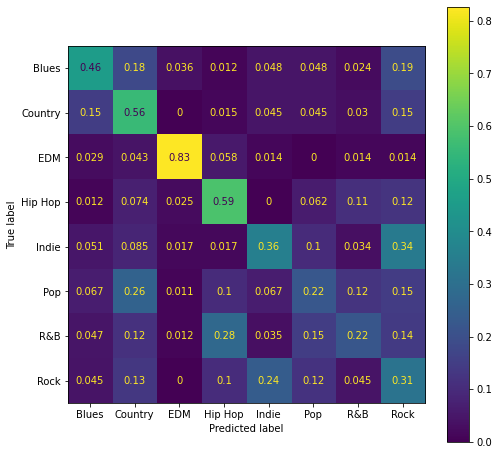

In [ ]:

## old
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax)

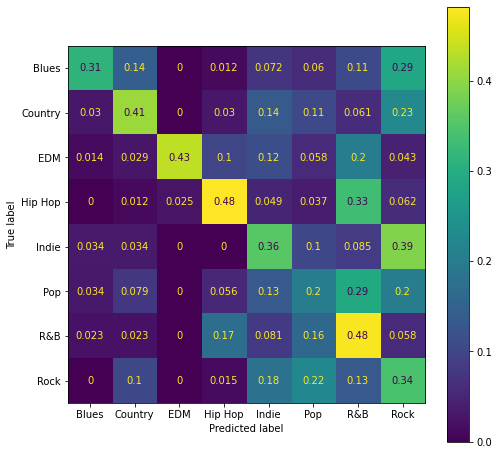

In [ ]:
## old

fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels2, y_pred=pred_labels2, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax)